In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob

# networks
import networkx as nx
from sklearn.covariance import GraphicalLassoCV

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [3]:
args.num_rois = 150
args.roi_size = 150
args.maintain_symmetry = True
args.brain_div = 'sub'

DESC = (
    f'type-functional'
    f'_nrois-{args.num_rois}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
)

BASE_path = f'{os.environ["HOME"]}/mouse_dataset/roi'
TS_path = f'{BASE_path}/{DESC}/roi_timeseries'
FC_path = f'{BASE_path}/{DESC}/func_nws'
os.system(f'mkdir -p {FC_path}')
NPY_path = f'{BASE_path}/{DESC}/npy_files'
os.system(f'mkdir -p {NPY_path}')

0

In [4]:
def create_dataframe(files):
    def get_ts(file):
        ts = np.loadtxt(file)
        ts = stats.zscore(ts, axis=0, nan_policy='omit')
        return ts

    def get_fc(ts):
        fc = np.corrcoef(ts, rowvar=False)
        fc = fc[np.tril_indices(fc.shape[0], k=-1)]
        fc[np.isnan(fc)] = 0.0
        fc = fc > np.percentile(fc, q=args.percentile) # this removes neg. edges
        
        fc_ = np.zeros((args.num_rois, args.num_rois))
        fc_[np.tril_indices(fc_.shape[0], k=-1)] = fc
        fc_ = (fc_ + fc_.T)
        return fc_

    def save_edges_to_file(fc, ssr):
        edges = np.stack(np.where(np.tril(fc, k=-1)), axis=-1)
        nw_edges_file = '_'.join(ssr[:-1] + ['desc-nw-edges.txt'])
        with open(f'{FC_path}/{nw_edges_file}', 'w', newline='') as f:
            wr = csv.writer(f, delimiter='\t')
            wr.writerows(edges)

    dataset_df = []

    for file in tqdm(files):
        ssr = file.split('/')[-1].split('_')
        # if int(seed) > 25: continue
        sub, ses, run = [ssr[i].split('-')[-1] for i in range(3)]
        ts = get_ts(file)
        fc = get_fc(ts)
        df = pd.DataFrame({
            'sub':[int(sub[-2:])],
            'ses':[int(ses)],
            'run':[int(run)],
            'ts':[ts],
            'fc':[fc],
        })
        dataset_df.append(df)
        save_edges_to_file(fc, ssr)
        
    dataset_df = pd.concat(dataset_df)
    dataset_df = dataset_df.sort_values(
        by=['sub', 'ses', 'run'],
    ).reset_index(drop=True)
    return dataset_df

In [5]:
args.percentile = 80

dataset_df = create_dataframe(files=glob.glob(f'{TS_path}/*', recursive=True))
with open(f'{NPY_path}/func_nws.npy', 'wb') as f:
    pickle.dump(dataset_df, f)

100%|██████████| 116/116 [00:02<00:00, 46.36it/s]


<Axes: >

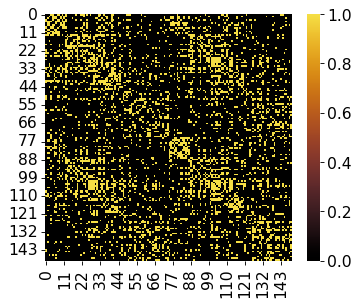

In [6]:
sub, ses, run = 3, 2, 5
row = dataset_df[
    (dataset_df['sub'] == sub) & 
    (dataset_df['ses'] == ses) & 
    (dataset_df['run'] == run)
]
fig, axs = plt.subplots(1, 1, figsize=(5, 4), dpi=80)
ax = axs
sns.heatmap(row['fc'].to_list()[0], ax=ax, square=True, cmap=cmr.iceburn, center=0)